<a href="https://colab.research.google.com/github/allansuzuki/OCR_credit_card/blob/main/read_credit_card.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit card OCR with OpenCV and Python

The purpouse of this project is to develop an OCR engine to read the number of credit cards automatically.
The learning purpose is more about **image processing techniques** and perform computer vision tasks without using already made OCR platforms.

## OCR

**What is OCR?**

> OCR (Optimal Character Recognition) is sometimes referred to as text recognition. An OCR program extracts and repurposes data from scanned documents, camera images and image-only pdfs. OCR software singles out characters (letters and numbers) on the image. It also eliminates the need for manual data entry.

Source: _https://www.ibm.com/cloud/blog/optical-character-recognition_


**For what purpose OCR is used?**

> The most well-known use case for optical character recognition (OCR) is converting printed paper documents into machine-readable text documents. Once a scanned paper document goes through OCR processing, the text of the document can be edited with a word processor like Microsoft Word or Google Docs.
OCR is often used as a hidden technology, powering many well-known systems and services in our daily life. Important — but less-known — use cases for OCR technology include data-entry automation, assisting blind and visually impaired persons and indexing documents for search engines, such as passports, license plates, invoices, bank statements, business cards and automatic number plate recognition.

Source: _https://www.ibm.com/cloud/blog/optical-character-recognition_

# Hands-on

## Business approach

It's expected the engine receive and img in png or jpg, recognize the credit card digit and output the digits, the credit card provider and the image of the credit card OCR'd (boundaries + text)

## Technichal approach

We want to build single command to receive the credit card image and output the information.<br>
First of all, we receive the image of the credit card. <br>
Then, the image is processed in order to find the boundaries of the 4 groups each with 4 digits in the credit card <br>
Following, the boundaries are applied to the image and try to read all the digits <br>
These digits are compared with [OCR-A fonts](https://en.wikipedia.org/wiki/OCR-A), same standard as the credit card numbers. <br>
Finally, the digits are recognized and written in a image with the credit card along with the credit card number and its provider.

In [ ]:
#install
!pip install --upgrade imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#imports
from imutils import contours
import numpy as np
import imutils
import cv2
from google.colab.patches import cv2_imshow     #used only in google colab

In [ ]:
# class and functions
class creditCard():
    def __init__(self, card_img, reference_fonts=None):
        self.card_img = card_img
        self.ref_fonts = self._mapping_ocr_fonts(reference_fonts)
        # define a dictionary with credit card providers
        self._prov_dict = {
            "3": "American Express",
	        "4": "Visa",
	        "5": "MasterCard",
	        "6": "Discover Card"
        }

    def get_provider(self, first_digit):
        # return provider name from the card first digit
        return self._prov_dict[first_digit]

    def _mapping_ocr_fonts(self, reference_fonts):
        #load ocr-a fonts image
        if reference_fonts is None: reference_fonts='ref/ocr-a-fonts.png'
        ref = cv2.imread(reference_fonts)   # read the img from filepath
        ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY) # Converts an image from one color space to another.
        ref = cv2.threshold(            # Applies a fixed-level threshold to each array element.
            ref,
            np.min(ref)+1,              # set the threshold value
            np.max(ref),                # set the maximum value when using THRESH_BINARY and THRESH_BINARY_INV methods
            cv2.THRESH_BINARY)[1]       # apply the method THRESH_BINARY_INV and return only the img matrix




**Store OCR-A fonts as reference**

Here we used the OpenCV image processing library to process our image.

First, we load the image using `imread()` function, which load and image and return a `np.array` (or matrix) with shape (height, width and channels). Channels are the layers of color channels, that combined together shows the colors of the original image.

Thus, we convert the image color to gray using the function `cv2.cvtColor()` which converts an image from one color space (ex: RGB) to another colo space (ex: BGR). We use the `cv2.BGR2GRAY` to convert the 3-channel image to a single channel grayscale.

Finally, we apply the threshold which is a limit to each value in each pixel. in the case of `THRESH_BINARY`, the lower values receive 0 (turns black) and the greater values receive the `max_value` set.
Hence, we have as final output an image with the digits in with in a black background.

All the threshold types are in [OpenCV Docs: ThresholdTypes](https://docs.opencv.org/4.7.0/d7/d1b/group__imgproc__misc.html#gaa9e58d2860d4afa658ef70a9b1115576)

original:


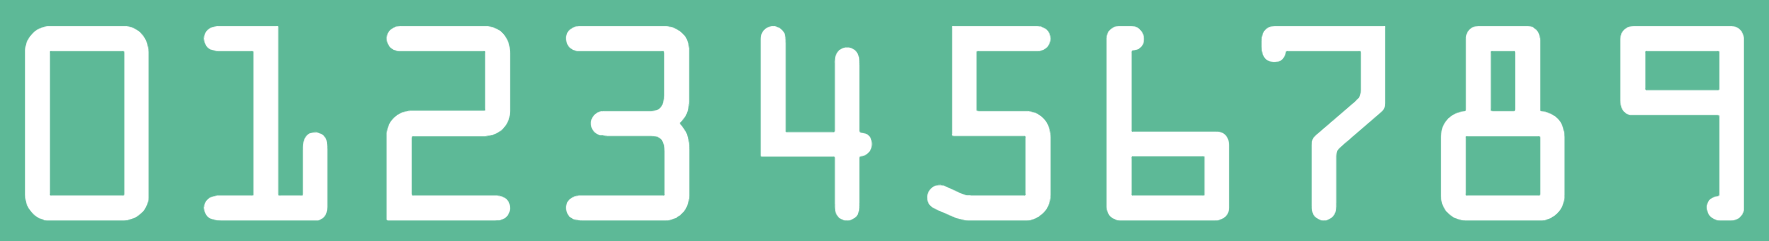


grey:


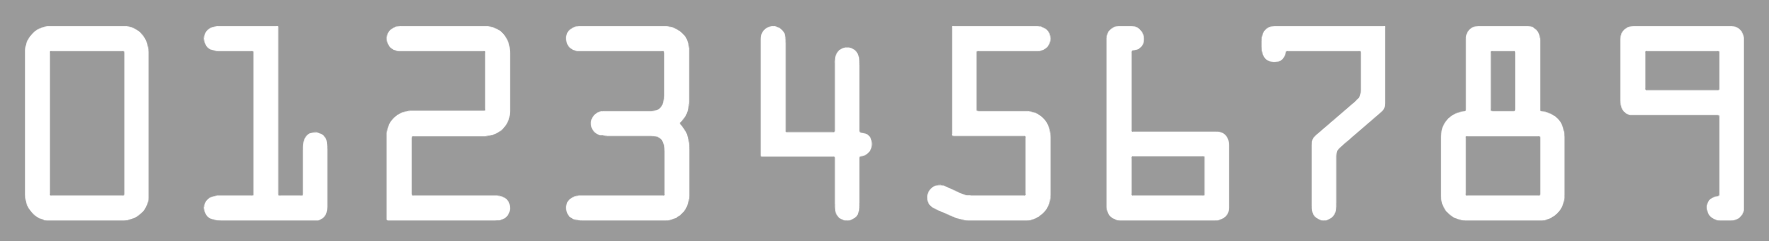


thresh:


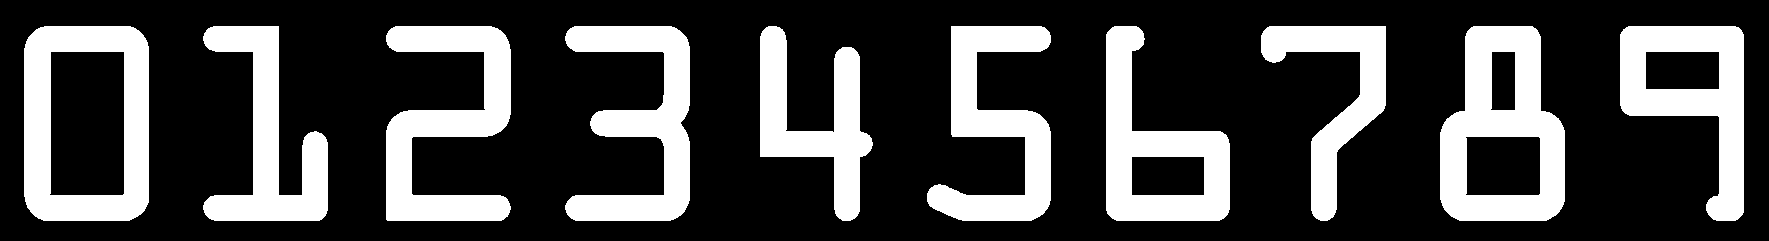

In [ ]:
#@title
reference_fonts='ref/ocr-a-fonts.png'
original = cv2.imread(reference_fonts)   # read the img from filepath
print('original:')
cv2_imshow(original)
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY) # Converts an image from one color space to another.
print('\ngrey:')
cv2_imshow(gray)
bw = cv2.threshold(            # Applies a fixed-level threshold to each array element.
    gray,
    np.min(gray)+1,              # set the threshold value
    np.max(gray),                # set the maximum value when using THRESH_BINARY and THRESH_BINARY_INV methods
    cv2.THRESH_BINARY)[1]       # apply the method THRESH_BINARY_INV and return only the img matrix
print('\nthresh:')
cv2_imshow(bw)

We can see below each image has three channels.
Each channel is a matrix with (height, width) and values related to each channel for each color.

In our case, the image is in the color space BGR (Blue, Green, Red).

original (combination of channels 1, 2 and 3)
shape (height, width, channels): (241, 1769, 3)


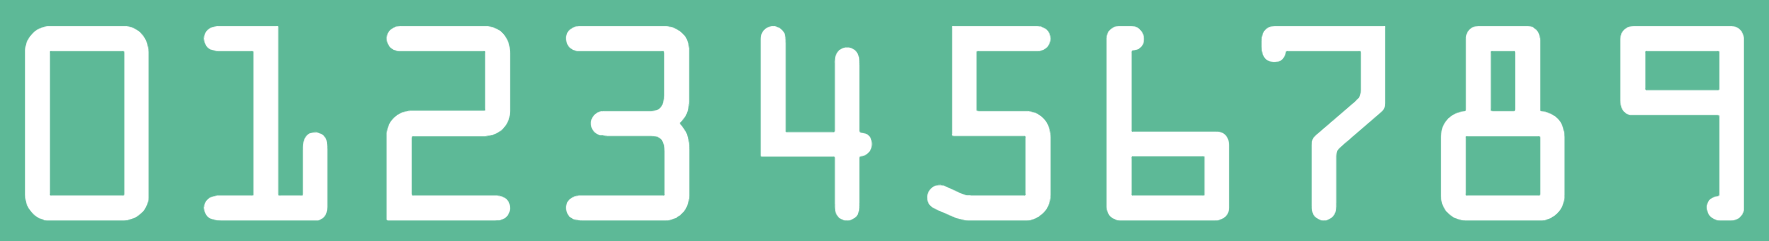


channel: 0


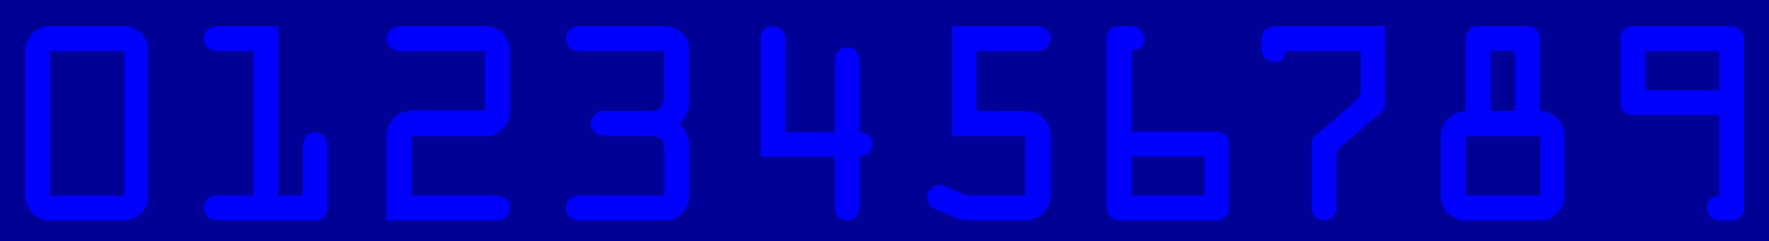


channel: 1


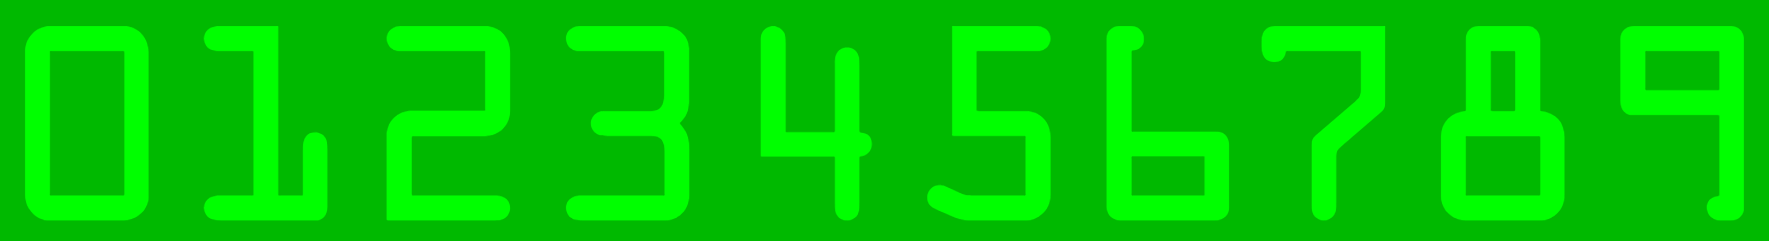


channel: 2


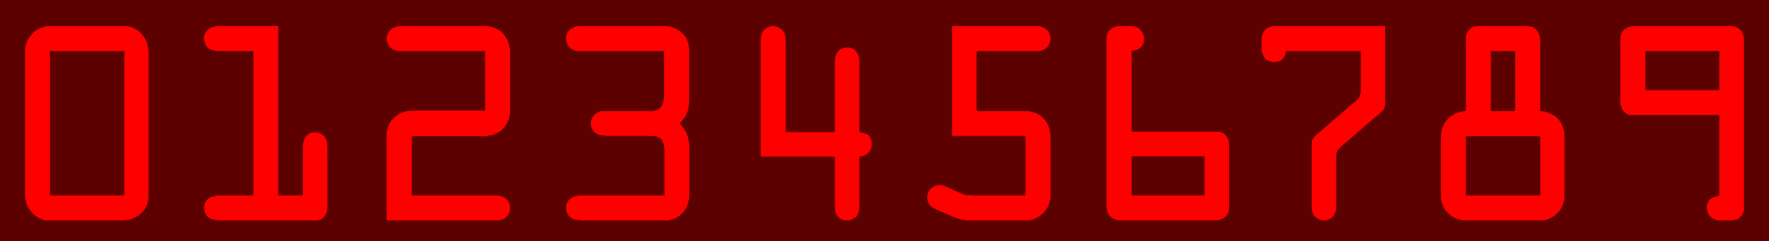

In [ ]:
#@title
print('original (combination of channels 1, 2 and 3)')
print('shape (height, width, channels):', np.shape(original))
cv2_imshow(original)
for i in range(np.shape(original)[-1]):
    print('\nchannel:',i)
    channel = np.zeros_like(original)
    channel[:,:,i] = original[:,:,i]
    cv2_imshow(channel)

After having our digits in a black background, we want to retrieve the contours, i.e. the outlines of the digits.

Then we sort the contours from left-to-right to assingn to the numbers.

In [ ]:
refCnts = cv2.findContours(bw,                      # Finds contours in a binary image.
                 mode=cv2.RETR_EXTERNAL,            # retrieves only the extreme outer contours
                 method=cv2.CHAIN_APPROX_SIMPLE,    # compresses horizontal, vertical, and diagonal segments and leaves only their end points
                 )
refCnts = imutils.grab_contours(refCnts)            # transform the cv2 contours to imutils contours
refCnts = contours.sort_contours(refCnts, method='left-to-right')[0]    #sort contours to right

In [ ]:
# make a copy to easy-use
ref = bw.copy()

# create a digit dict to map
digits = dict()

#create a list of boundary boxes
box_numbers = list()

# loop over the contours
for i,c in enumerate(refCnts):
    # compute the bounding box for the digit, extract it and resize
    (x,y,h,w) = cv2.boundingRect(c)     # get the bound box
    roi = bw[y:y+h, x:x+w]              # return the pixels from the image
    roi = cv2.resize(roi, (57,88))      # resize img
    box_numbers.append((x,y,h,w))       # store boxes results

    # create a digit mapping assign number to the representation image
    digits[i] = roi


Original:


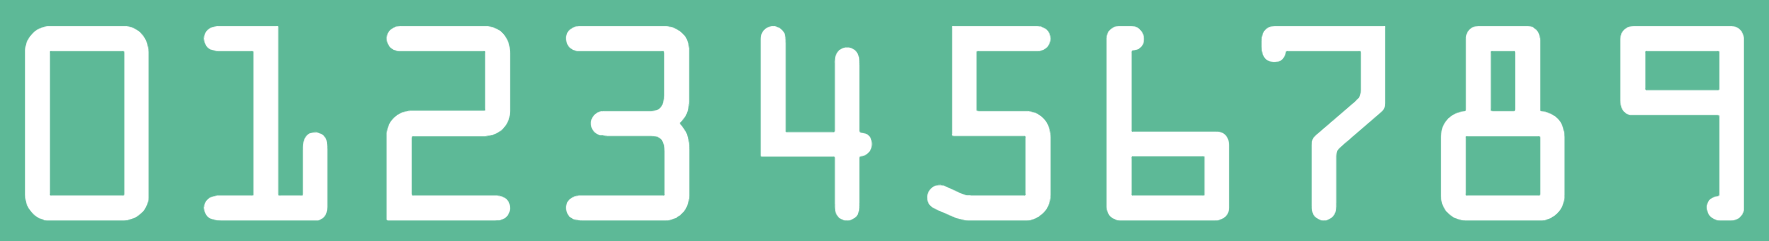


Original with contours:


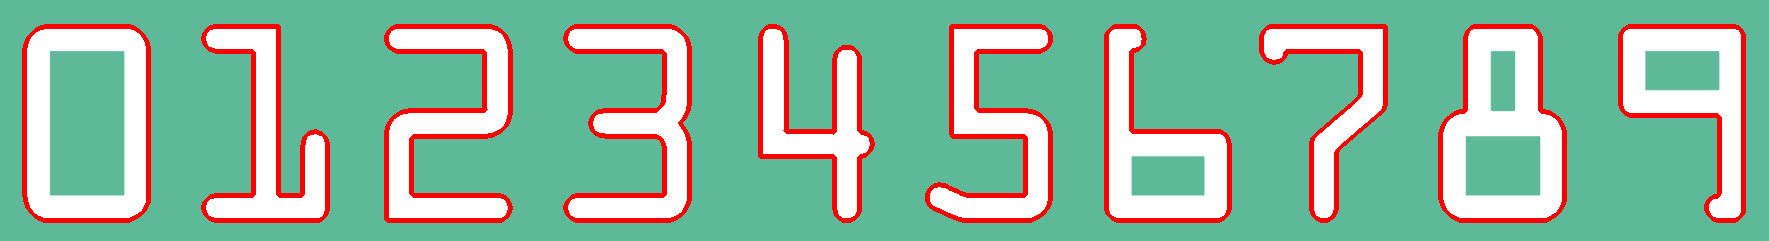

In [ ]:
img_w_cnts = cv2.drawContours(original.copy(), refCnts, -1, (0,0,255), 3)
img_w_boxes = cv2.rectangle(original.copy(), )
print('\nOriginal:')
cv2_imshow(original)
print('\nOriginal with contours:')
cv2_imshow(img_w_cnts)